In [7]:
from pathlib import Path
import re, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [8]:
root = Path(r"C:\Users\garvi\.cache\kagglehub\datasets\sorour\95cloud-cloud-segmentation-on-satellite-images\versions\3\95-cloud_training_only_additional_to38-cloud")

# exact folder names in your printout
red_dir   = root / "train_red_additional_to38cloud"
green_dir = root / "train_green_additional_to38cloud"
blue_dir  = root / "train_blue_additional_to38cloud"
nir_dir   = root / "train_nir_additional_to38cloud"
gt_dir    = root / "train_gt_additional_to38cloud"

In [9]:
print(red_dir)

C:\Users\garvi\.cache\kagglehub\datasets\sorour\95cloud-cloud-segmentation-on-satellite-images\versions\3\95-cloud_training_only_additional_to38-cloud\train_red_additional_to38cloud


In [20]:
image_path="_patch_158_8_by_18_LC08_L1TP_034047_20160520_20170324_01_T1.TIF"
image_path_r="red"+image_path
image_path_g="green"+image_path
image_path_b="blue"+image_path
image_path_nir="nir"+image_path
image_path_gt="gt"+image_path

In [21]:
image_path_r=red_dir/image_path_r
image_path_g=green_dir/image_path_g
image_path_b=blue_dir/image_path_b
image_path_nir=nir_dir/image_path_nir
image_path_gt=gt_dir/image_path_gt

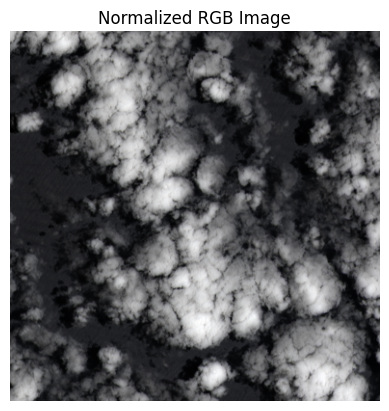

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load
R = np.array(Image.open(image_path_r)).astype(np.float32)
G = np.array(Image.open(image_path_g)).astype(np.float32)
B = np.array(Image.open(image_path_b)).astype(np.float32)
N = np.array(Image.open(image_path_nir)).astype(np.float32)

# Normalize each band to 0–1
def normalize(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x

R = normalize(R)
G = normalize(G)
B = normalize(B)
N = normalize(N)

# Stack as RGB
rgb = np.stack([R, G, B], axis=-1)
img = np.stack([R, G, B, N], axis=0)  
img_tensor = torch.tensor(img).unsqueeze(0)  

# Display
plt.imshow(rgb)
plt.title("Normalized RGB Image")
plt.axis("off")
plt.show()


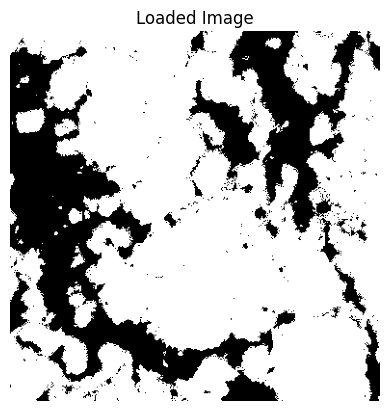

In [23]:
img = Image.open(image_path_gt).convert('L')
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("Loaded Image")
plt.show()

In [24]:
import torch

In [25]:
from models import UNetSmall

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_iou, best_path = 0.0, "unet_cloud95.pt"

model = UNetSmall(in_ch=4, out_ch=1).to(device)

ckpt = torch.load(best_path, map_location=device)

state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt

model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [29]:
model.eval()
with torch.no_grad():
    pred = torch.sigmoid(model(img_tensor))  # (1, 1, H, W)
# pred_mask = pred.squeeze().numpy()
pred_mask = (pred > 0.5).float().squeeze().cpu().numpy()

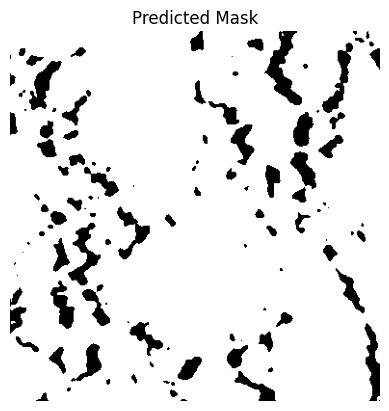

In [31]:
plt.imshow(pred_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")
plt.show()

In [19]:
print(R.shape)

(384, 384)
